![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=Vertex+AI+AutoML+Forecasting+-+Python+client.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FVertex%2520AI%2520AutoML%2520Forecasting%2520-%2520Python%2520client.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI AutoML Forecasting - Python client

In this notebook we fit a forecasting model to the data reviewed and prepared in the [preparation notebook](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb) - citibike bike rentals daily volume by station near Central Park in New York City. For this attempt the forecasting will be done with [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform) managed service for forecasting: [Vertex AI Forecasting](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/overview).  This service includes training for neural network model types:
- [AutoML](./Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb) (**This Notebook**)
    - Great choice for all range of use cases
    - Blog: [Using AutoML for Time Series Forecasting](https://ai.googleblog.com/2020/12/using-automl-for-time-series-forecasting.html)
- [Seq2Seq+](./Vertex%20AI%20Seq2Seq+%20Forecasting%20-%20Python%20client.ipynb)
    - A simplier architecture with smaller search space.  Good for experimentation and smaller datasets and smaller time budgets.
- [Temporal Fusion Transformer (TFT)](./Vertex%20AI%20Temporal%20Fusion%20Transformer%20Forecasting%20-%20Python%20client.ipynb)
    - Attention-based DNN for high accuracy and interpretability. 
    - Blog: [Interpretable Deep Learning for Time Series Forecasting](https://ai.googleblog.com/2021/12/interpretable-deep-learning-for-time.html)
    - Research Paper: [Temporal Fusion Transformers for interpretable multi-horizon time series forecasting](https://www.sciencedirect.com/science/article/pii/S0169207021000637)
- [Time series Dense Encoder (TiDE)](./Vertex%20AI%20Time%20series%20Dense%20Encoder%20-%20Python%20client.ipynb)
    - Optimzed dense DNN-based encoder-decoder model.  Good for fast training and inference which help with long contexts and horizons.
    - Blog: [Recent advances in deep long-horizon forecasting – Google AI Blog](https://ai.googleblog.com/2023/04/recent-advances-in-deep-long-horizon.html)
    - Research Paper: [Long-term Forecasting with TiDE: Time-series Dense Encoder](https://arxiv.org/abs/2304.08424)

**NOTE:**
>This notebook uses the [Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest).  The approach used here with the Python client matches what is used in the [Vertex AI AutoML Forecasting - GCP Console (no code)](./Vertex%20AI%20AutoML%20Forecasting%20-%20GCP%20Console%20(no%20code).ipynb) notebook that shows the workflow using the Google Cloud Console (no code).  The one parameter that is changed in the model specification is the context window which is set to 28 here and 14 in the prior notebook.  These context windows are compared with additional context windows in the notebook [Vertex AI AutoML Forecasting - multiple simultaneously](./Vertex%20AI%20AutoML%20Forecasting%20-%20multiple%20simultaneously.ipynb)

Vertex AI Forecasting methods allow users to create accurate and scalable forecasting by specifying their data source, parameters that describe the data, and training time (in hours). Source and output data can be files in a GCS bucket or BigQuery Tables. These forecasting methods handle many factors that may descibe the shape of the data like:
- [hierarchical forecasting](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/hierarchical), both groups and temporal. For example: products within categories (groups) and/or daily sales rolling up to weekly (temporal).
- [weights](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/prepare-data#weight) that change the importance of training rows.  For example: a higher weight might be applied to measurment on a manufacturing line just after calibration, the deacreasing weight over the time until the next calibration.
- [granularity](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#granularity) to specify the aggregation level of the data and is used to both validate the data (multiple measurments for time point) and handle missing time points. When working with minute level granularity you can also specify the quantity between measurments like 1, 5, 10, 15, or 30 minutes.
- holidays for one or more regions and/or individual countries
- The [forecast window](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#context-window) which is comprised of:
    - forecast horizon, or how far into the future to predict
    - context window, or how far back the model looks for patterns that impact a time point
    - Control the number and frequency of windows with a custom [window strategy](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#rolling_window_strategies)
        - counts - set the number of windows
        - stride - set the interval between windows.  Using 7 for a daily forecast would only create a forecast for one day each week.
        - column - provide a column of True/False values the determines which rows are used to generate a window
- [Optimization Objective](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#optimization-objectives) can be choosen to tailor forecasting in scenarios where extreme values may be present or ranges are are uniquely high/low.
- [Specify features](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#feature-type) (attributes and covariates):
    - attributes the describe a time series
    - time varying covariates that are known in advance like holidays, promotions, scheduled deliveries
    - time varying covariates that are not known in advance like weather, traffic, downtime
- [transform features](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#transformations) like tokenizing text strings
- [split](https://cloud.google.com/vertex-ai/docs/tabular-data/data-splits#forecasting) data by providing a column with splits or parameters to control the splitting into train, validate, and test sets using chronological order

---

**Series Overview**

[This series](./readme.md) explores forecasting with Vertex AI, BigQuery ML, and additional open source frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Some method also incoporate observable measurements that impact demand to understand the relationships and make forecasting more accurate.

**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at:: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

**Vertex AI Overview**

[Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform) is a machine learning platform for [training](https://cloud.google.com/vertex-ai/docs/training-overview), [evaluating](https://cloud.google.com/vertex-ai/docs/evaluation/introduction), [deploying](https://cloud.google.com/vertex-ai/docs/predictions/overview), and [monitoring](https://cloud.google.com/vertex-ai/docs/model-monitoring) ML models.  It tools for exploration with [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction) and tools for workflow and automation with [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction). 

Vertex AI amplifies this flow with many fit-for-purpose offering. Examples include
- Manage Models with
    - [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction) with versioning
    - Understanding models using [Vertex AI Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview) including feature-based) and example-based explanations
- Better Training with
    -[ Pre-Built Training containers](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) for many common frameworks that automatically hangle GPU setup, mount GCS for file retrieval, and even work with NFS mounts
    - Managed [Vertex AI Tensorboard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) for live model training views that persist for tracking throughout Vertex AI
    - [Experiment tracking](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments) with automatic metric logging with [autolog](https://cloud.google.com/vertex-ai/docs/experiments/autolog-data)
    - Track and analyze by querying Vertex AI ML Metadata
- Scale Training with 
    - Easily configured [disributed training](https://cloud.google.com/vertex-ai/docs/training/distributed-training)
    - [Redution server](https://cloud.google.com/vertex-ai/docs/training/distributed-training#reduce_training_time_with_reduction_server) for faster training
    - [Hyperparameter tuning](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) including [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview)
    - Training with [TPU accelerators](https://cloud.google.com/vertex-ai/docs/training/training-with-tpu-vm)
- Scale Predictions with
    - [Pre-built Serving container](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) for many common frameworks
    - [Endpoints](https://cloud.google.com/vertex-ai/docs/general/deployment) that [scale](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute#scaling) and have [traffic splitting](https://cloud.google.com/vertex-ai/docs/general/deployment#models-endpoint)
    - [Use private endpoints](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints) for secure and fast predictions.
    - Co-host models with [shared resources across deployments](https://cloud.google.com/vertex-ai/docs/predictions/model-co-hosting)
    - [Custom prediction routines](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) to easily build custom serving containers that extend models by preprocessing and postprocessing: process inputs, make calls to external services for additional data, process outputs.
    - [NVIDA Triton Inference Server](https://cloud.google.com/vertex-ai/docs/predictions/using-nvidia-triton) for codeploying multiple models, even multiple frameworks, with direct access and ensembling.
    - [batch predictions](https://cloud.google.com/vertex-ai/docs/predictions/overview#batch_predictions)
    
- Feature management with [Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/overview)
- Fast, scalable nearest neightbor service with the low latency vector database [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
- Highly configurage workflows on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) that run KFP and TFX pipleines with serverless backend and includes [pre-built components](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction) for [GCP (like Dataproc and Dataflow)](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#dataproc_sl_components) and [Vertex AI](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#vertex_ai_components) services

---

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources:**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python Client](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest)
    - [Vertex AI AutoML Forecasting](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#api)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore4_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore4_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'automl-python'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

packages:

In [6]:
from google.cloud import aiplatform
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

clients:

In [7]:
bq = bigquery.Client(project=PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [38]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

---
## Review Time Series

**Univariate Forecasting** consists of just 2 columns per time series:
- `TARGET_COLUMN` = The demand measurment.
    In our case it is the number of trips taken per day from a particular bike station - the sum of trips for a day.
- `TIME_COLUMN` = The time of demand.
    Expressed in the time or date units related to the granularity of the forecast exercise.  In our case, demand is measured daily so the time column is prepared as a date.

**Additional Columns** are used to instruct the forecasting algorithms handling of the data:
- `SERIES_COLUMN` groups rows associated with the same time series.
    - Conducting multiple forecasts, one per time series, means including a third column to capture the groups of row for each time series: `SERIES_COLUMN`.
    - **NOTE:** BigQuery ARIMA+ fits separate forecast for each time series. 
- `SPLITS_COLUMN` groups sequential rows within each time series for their purpose during the forecasting exercise.
    - This data was prepared with splits for `TRAIN`, `VALIDATE` and `TEST` in the prerequisite notebooks.  The column that contains these splits can be used by the choosen forecast method during training rather than have the method calculate the splits.  This can be helpful when comparing multiple different methods as it ensures splitting is handled the same across each method.
- `COVARIATE_COLUMNS` is a list of columns that measure additional features over time.  Some forcasting methods can use these to imporove the understanding of trends and make better forecasts.  Univarate forecast methods will not use these.  To use a covariate for forecasting then its value needs to be know in advance to be used when making predictions, or the forecast method will need to have special handling for unknown covariates.  The three types of covariate information are:
    - Attributes
        - Values that do not change over time but describe what the time series represents.  In our case a bike station might be identified by latitude and longitude, color, number of bike slots.
    - Covariates that are available (known) at forecast time (in advance)
        - These are measurements that can be known ahead of time like when holidays occur, promotions, events, changes in capacity.
    - Covariates that are unavailable (unknown) at forecast time (in advance)
        - Measurements that change over time but are not known until the time of measurment like rain, other weather, foot traffic, and queue length.

**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows  
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [10]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
#COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty
COVARIATE_COLUMNS_ATTRIBUTES = []
COVARIATE_COLUMNS_KNOWN = ['capacity']
COVARIATE_COLUMNS_UNKNOWN = ['avg_tripduration', 'pct_subscriber', 'ratio_gender']

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

Retrieve Key Dates for splits:

In [11]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Retrieve raw data:

In [12]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {SPLIT_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

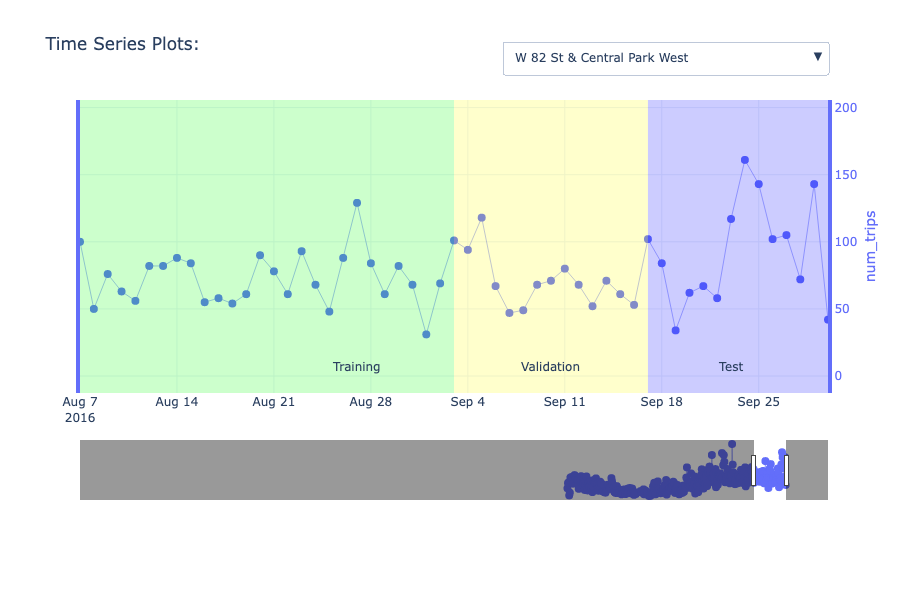

In [84]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


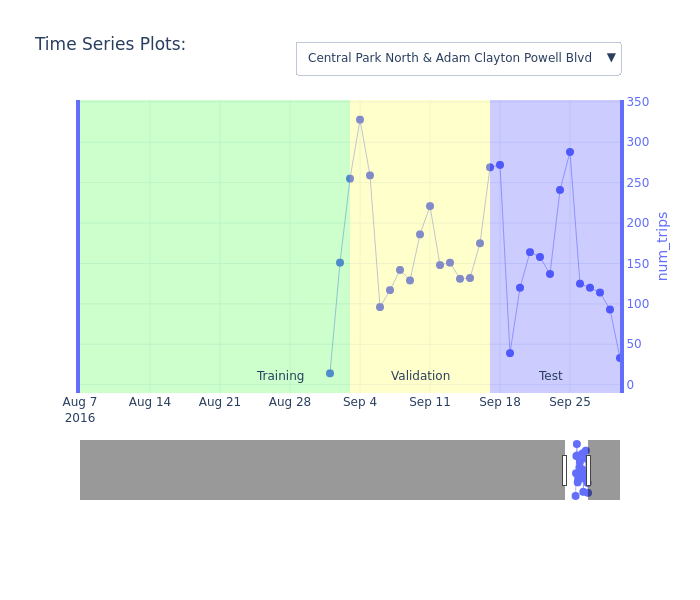

In [14]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Create Forecast Model

Vertex AI Forecasting methods allow users to create accurate and scalable forecasting by specifying their data source, parameters that describe the data, and training time (in hours). Source and output data can be files in a GCS bucket or BigQuery Tables. These forecasting methods handle many factors that may descibe the shape of the data like:
- [hierarchical forecasting](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/hierarchical), both groups and temporal. For example: products within categories (groups) and/or daily sales rolling up to weekly (temporal).
- [weights](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/prepare-data#weight) that change the importance of training rows.  For example: a higher weight might be applied to measurment on a manufacturing line just after calibration, the deacreasing weight over the time until the next calibration.
- [granularity](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#granularity) to specify the aggregation level of the data and is used to both validate the data (multiple measurments for time point) and handle missing time points. When working with minute level granularity you can also specify the quantity between measurments like 1, 5, 10, 15, or 30 minutes.
- holidays for one or more regions and/or individual countries
- The [forecast window](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#context-window) which is comprised of:
    - forecast horizon, or how far into the future to predict
    - context window, or how far back the model looks for patterns that impact a time point
    - Control the number and frequency of windows with a custom [window strategy](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#rolling_window_strategies)
        - counts - set the number of windows
        - stride - set the interval between windows.  Using 7 for a daily forecast would only create a forecast for one day each week.
        - column - provide a column of True/False values the determines which rows are used to generate a window
- [Optimization Objective](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#optimization-objectives) can be choosen to tailor forecasting in scenarios where extreme values may be present or ranges are are uniquely high/low.
- [Specify features](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#feature-type) (attributes and covariates):
    - attributes the describe a time series
    - time varying covariates that are known in advance like holidays, promotions, scheduled deliveries
    - time varying covariates that are not known in advance like weather, traffic, downtime
- [transform features](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#transformations) like tokenizing text strings
- [split](https://cloud.google.com/vertex-ai/docs/tabular-data/data-splits#forecasting) data by providing a column with splits or parameters to control the splitting into train, validate, and test sets using chronological order

---
### Create Dataset (Link to BigQuery Table)

A Vertex AI Dataset is the input for Vertex AI Forecasting Jobs (AutoML, Seq2Seq, TFT).  This creates a link between Vertex AI and the external data that does not copy the data from its source. Changes made to the source will apply to all models trained on the data starting at the time of the change.

Resources:
- [Documentation](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/create-dataset) for forecasting dataset
- Python SDK reference for [aiplatform.TimeSeriesDataset.create()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.TimeSeriesDataset#google_cloud_aiplatform_TimeSeriesDataset_create)

In [31]:
if SERIES in [ds.display_name for ds in aiplatform.TimeSeriesDataset.list()]:
    dataset = aiplatform.TimeSeriesDataset.list(filter = f'display_name={SERIES}')[0]
else:
    dataset = aiplatform.TimeSeriesDataset.create(
        display_name = f'{SERIES}', 
        bq_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
    )

print(f'Created/Retrieve Dataset: {dataset.display_name}')

Created/Retrieve Dataset: applied-forecasting


In [33]:
dataset.column_names

['ratio_gender',
 'pct_subscriber',
 'splits',
 'starttime',
 'start_station_name',
 'capacity',
 'avg_tripduration',
 'num_trips']

---
### Train Forecasting Model with Vertex AI AutoML

#### Model Registry Work

The result of an Vertex AI Forecasting Job (AutoML, Seq2Seq, TFT) is a model in the Vertex AI Model Registry.  These models have versioning so if this notebook has been run before we could add a new run as a new verison to the same model in the registry.  To do this we first check the model registry for an existing model from this notebook (using the `SERIES` and `EXPERIMENT` parameters).

In [39]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

if modelmatch:
    print("There is an existing model with versions: ", [f'{m.version_id}' for m in modelmatch])
    parent = modelmatch[0].resource_name
else:
    print("This is the first training for this model")
    parent = ''

This is the first training for this model


#### Create AutoML Forecasting Job

Create an AutoML forecasting job by setting up the parameters.

Resources:
- [Documentation](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#train_a_model) for forecasting job
- Python SDK reference for [aiplatform.AutoMLForecastingTrainingJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.AutoMLForecastingTrainingJob)

First, for columns that are used in the model, set their specs to `auto`.  Omit the columns used to split the data and identify the time series:

In [40]:
column_specs = dict.fromkeys(
    list(
        set(dataset.column_names) - set([SPLIT_COLUMN, SERIES_COLUMN])
    ),
    'auto'
)
column_specs

{'ratio_gender': 'auto',
 'pct_subscriber': 'auto',
 'starttime': 'auto',
 'capacity': 'auto',
 'avg_tripduration': 'auto',
 'num_trips': 'auto'}

In [41]:
forecasting_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}',
    optimization_objective = "minimize-rmse",
    column_specs = column_specs,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
)

#### Run AutoML Forecasting Job

Running the job is the point where the parameterization of the forecasting takes place.

Python SDK reference for [aiplatform.AutoMLForecastingTrainingJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.AutoMLForecastingTrainingJob#google_cloud_aiplatform_AutoMLForecastingTrainingJob_run)

In [42]:
forecast = forecasting_job.run(
    # data parameters
    dataset = dataset,
    target_column = TARGET_COLUMN,
    time_column = TIME_COLUMN,
    time_series_identifier_column = SERIES_COLUMN,
    time_series_attribute_columns = COVARIATE_COLUMNS_ATTRIBUTES,
    unavailable_at_forecast_columns = [TARGET_COLUMN] + COVARIATE_COLUMNS_UNKNOWN,
    available_at_forecast_columns = [TIME_COLUMN] + COVARIATE_COLUMNS_KNOWN,
    predefined_split_column_name = SPLIT_COLUMN,
    
    # forecast parameters
    forecast_horizon = FORECAST_HORIZON_LENGTH,
    data_granularity_unit = FORECAST_GRANULARITY,
    data_granularity_count = 1,
    context_window = 28,
    holiday_regions = ['GLOBAL', 'NA', 'US'],
    
    hierarchy_group_columns = [],
    hierarchy_group_total_weight = 1.0,
    hierarchy_temporal_total_weight = 2.0,
    hierarchy_group_temporal_total_weight = 1.0,
    
    # output parameters
    export_evaluated_data_items = True,
    export_evaluated_data_items_bigquery_destination_uri = f"bq://{BQ_PROJECT}:{BQ_DATASET}:{EXPERIMENT}_eval",
    export_evaluated_data_items_override_destination = True,
    
    # running parameters
    validation_options = "fail-pipeline",
    budget_milli_node_hours = 1000,
    
    # model parameters
    model_display_name = f"{SERIES}_{EXPERIMENT}",
    model_labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'},
    model_id = f"model_{SERIES}_{EXPERIMENT}",
    parent_model = parent,
    is_default_version = True,
    
    # session parameters: False means continue in local session, True waits and logs progress
    sync = True
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3842173426835914752?project=1026793852137


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3842173426835914752?project=1026793852137


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob run completed. Resource name: projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob run completed. Resource name: projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752


Model available at projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python


INFO:google.cloud.aiplatform.training_jobs:Model available at projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python


Exported examples available at:
bq://statmike-mlops-349915.applied_forecasting.automl-python_eval


INFO:google.cloud.aiplatform.training_jobs:Exported examples available at:
bq://statmike-mlops-349915.applied_forecasting.automl-python_eval


In [45]:
forecast.display_name, forecast.resource_name

('applied-forecasting_automl-python',
 'projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python')

In [93]:
forecast.name

'model_applied-forecasting_automl-python'

In [96]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{forecast.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_applied-forecasting_automl-python?project=statmike-mlops-349915


---
## Forecasting

### Retrieve Test Data

Start with a short sample.  Notice the `TIME_COLUMN` (starttime) has repeating rows as the dates progress.  The build up to the size of the context window.  Also notice the column `predicted_on_####` which has date of the context.  

In [49]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
LIMIT 20
"""
bq.query(query = query).to_dataframe()

,avg_tripduration,capacity,num_trips,pct_subscriber,predicted_num_trips,predicted_on_starttime,ratio_gender,start_station_name,starttime
0,1808.631970,36,269,0.423792,{'value': 205.3329315185547},2016-09-17,0.469945,Central Park North & Adam Clayton Powell Blvd,2016-09-17
1,2027.411765,36,272,0.367647,{'value': 214.0391845703125},2016-09-18,0.346535,Central Park North & Adam Clayton Powell Blvd,2016-09-18
2,2027.411765,36,272,0.367647,{'value': 204.28514099121094},2016-09-17,0.346535,Central Park North & Adam Clayton Powell Blvd,2016-09-18
3,1203.820513,36,39,0.743590,{'value': 174.4519500732422},2016-09-18,1.600000,Central Park North & Adam Clayton Powell Blvd,2016-09-19
4,1203.820513,36,39,0.743590,{'value': 186.8390350341797},2016-09-19,1.600000,Central Park North & Adam Clayton Powell Blvd,2016-09-19
5,1203.820513,36,39,0.743590,{'value': 163.76895141601562},2016-09-17,1.600000,Central Park North & Adam Clayton Powell Blvd,2016-09-19
6,1750.691667,36,120,0.625000,{'value': 164.14614868164062},2016-09-18,0.578947,Central Park North & Adam Clayton Powell Blvd,2016-09-20
7,1750.691667,36,120,0.625000,{'value': 153.3251190185547},2016-09-17,0.578947,Central Park North & Adam Clayton Powell Blvd,2016-09-20
8,1750.691667,36,120,0.625000,{'value': 176.6783905029297},2016-09-19,0.578947,Central Park North & Adam Clayton Powell Blvd,2016-09-20
9,1750.691667,36,120,0.625000,{'value': 174.81993103027344},2016-09-20,0.578947,Central Park North & Adam Clayton Powell Blvd,2016-09-20


Calculate the time between `TIME_COLUMN` and `prediction_on{TIME_COLUMN}` and keep the rows that are 0 = same day.  

In [97]:
query = f"""
SELECT
    DATE({TIME_COLUMN}) as {TIME_COLUMN},
    DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
    CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
    {SERIES_COLUMN},
    predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
test_predictions = bq.query(query = query).to_dataframe()
test_predictions

,starttime,predicted_on_starttime,num_trips,start_station_name,predicted_num_trips
0,2016-09-17,2016-09-17,269,Central Park North & Adam Clayton Powell Blvd,205.332932
1,2016-09-18,2016-09-18,272,Central Park North & Adam Clayton Powell Blvd,214.039185
2,2016-09-19,2016-09-19,39,Central Park North & Adam Clayton Powell Blvd,186.839035
3,2016-09-20,2016-09-20,120,Central Park North & Adam Clayton Powell Blvd,174.819931
4,2016-09-21,2016-09-21,164,Central Park North & Adam Clayton Powell Blvd,174.524857
...,...,...,...,...,...
154,2016-09-26,2016-09-26,102,W 82 St & Central Park West,79.936607
155,2016-09-27,2016-09-27,105,W 82 St & Central Park West,77.740044
156,2016-09-28,2016-09-28,72,W 82 St & Central Park West,76.187767
157,2016-09-29,2016-09-29,143,W 82 St & Central Park West,72.829346


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```

In [100]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            DATE({TIME_COLUMN}) as {TIME_COLUMN},
            DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
            CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
            {SERIES_COLUMN},
            predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
        WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
    ),
    DIFFS AS (
        SELECT 
            {SERIES_COLUMN},
            {TIME_COLUMN},
            'forecast' as time_series_type,
            predicted_{TARGET_COLUMN} as forecast_value,
            {TARGET_COLUMN} as actual_value,
            ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
        FROM FORECASTS   
    )
SELECT
    start_station_name,
    time_series_type, 
    AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
    AVG(ABS(diff)) as MAE,
    SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
FROM DIFFS
GROUP BY
    {SERIES_COLUMN},
    time_series_type
ORDER BY
    {SERIES_COLUMN},
    time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.877439,61.953306,0.399147,5491.889383,74.107283,0.477451
1,Central Park S & 6 Ave,forecast,0.534903,79.896469,0.244813,12824.413664,113.244928,0.346997
2,Central Park W & W 96 St,forecast,0.544955,27.438789,0.274192,1287.894850,35.887252,0.358616
3,Central Park West & W 100 St,forecast,0.754340,15.327849,0.386648,321.785004,17.938367,0.452499
4,Central Park West & W 102 St,forecast,0.462135,11.613624,0.229324,223.862354,14.962030,0.295442
5,Central Park West & W 68 St,forecast,0.505338,45.196494,0.298327,3098.348571,55.662811,0.367411
6,Central Park West & W 72 St,forecast,0.653566,49.688818,0.280850,4476.277881,66.904991,0.378159
7,Central Park West & W 76 St,forecast,0.370254,25.992556,0.237375,1162.695369,34.098319,0.311400
8,Central Park West & W 85 St,forecast,1.222576,55.254804,0.439527,4992.388541,70.656836,0.562043
9,Grand Army Plaza & Central Park S,forecast,0.566253,56.313103,0.258957,5686.655561,75.409917,0.346774


Overall Metrics:

In [101]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            DATE({TIME_COLUMN}) as {TIME_COLUMN},
            DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
            CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
            {SERIES_COLUMN},
            predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
        WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
    ),
    DIFFS AS (
        SELECT 
            {SERIES_COLUMN},
            {TIME_COLUMN},
            'forecast' as time_series_type,
            predicted_{TARGET_COLUMN} as forecast_value,
            {TARGET_COLUMN} as actual_value,
            ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
        FROM FORECASTS   
    )
SELECT
    #start_station_name,
    time_series_type, 
    AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
    AVG(ABS(diff)) as MAE,
    SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
FROM DIFFS
GROUP BY
    #{SERIES_COLUMN},
    time_series_type
ORDER BY
    #{SERIES_COLUMN},
    time_series_type  
"""
customMetricsOverall = bq.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.57638,38.820349,0.289854,3379.799126,58.13604,0.434075


---
### Get Forecasted Values for Future Horizon
Use a batch prediction job with the resulting forecasting model to get predicted forecast for the future horizon. 

The requirement for getting batch predictions from a Vertex AI forecasting model are covered [here](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/get-predictions).

#### Prepare Input Table in BigQuery
For Vetex AI forecasting batch prediction jobs we need a table (BigQuery or CSV) that contains a row per date in the forecast horizon and history for atleast the length of the context window. The following BigQuery query constructs this input table from the source data while also filling in missing dates in the context window with the last known observation.

In [70]:
context_window = 28

query_a = ""
query_b = ""
for v in COVARIATE_COLUMNS_KNOWN + COVARIATE_COLUMNS_UNKNOWN + COVARIATE_COLUMNS_ATTRIBUTES:
    query_a += f""",
            LAST_VALUE({v} IGNORE NULLS) OVER (PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {v}"""
    if v not in COVARIATE_COLUMNS_ATTRIBUTES:
        query_b += f""",
        CASE WHEN {TIME_COLUMN} > (SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) THEN NULL ELSE {v} END AS {v}"""
    else:
        query_b += f""",
        {v}"""

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_input` AS
WITH
    DATELIST AS (
        SELECT *
        FROM (SELECT DISTINCT {SERIES_COLUMN} FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) A
        CROSS JOIN (SELECT * 
                    FROM UNNEST(GENERATE_DATE_ARRAY(
                                    DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`), INTERVAL {context_window-1} DAY),
                                    DATE_ADD((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`), INTERVAL {FORECAST_HORIZON_LENGTH} DAY),
                                    INTERVAL 1 DAY
                                )
                            ) AS {TIME_COLUMN}
                    ) B
    ),
    ADDTARGET AS (
        SELECT *
        FROM DATELIST
        LEFT OUTER JOIN (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`)
        USING ({SERIES_COLUMN}, {TIME_COLUMN})
        ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
    ),
    LOCF AS (
        SELECT {SERIES_COLUMN}, {TIME_COLUMN},
        LAST_VALUE({TARGET_COLUMN} IGNORE NULLS) OVER (PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {TARGET_COLUMN}
        {query_a}
        FROM ADDTARGET
    )
SELECT {SERIES_COLUMN}, {TIME_COLUMN},
    CASE
        WHEN {TIME_COLUMN} > (SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) THEN NULL
        ELSE {TARGET_COLUMN}
    END AS {TARGET_COLUMN}
    {query_b}
FROM LOCF
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
job = bq.query(query = query)
job.result()

#### Batch Prediction Job

Request the batch prediction directly using the `batch_prediction()` method for the model - [SDK Reference](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_batch_predict).

In [72]:
batchjob = forecast.batch_predict(
    job_display_name = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}',
    bigquery_source = f"bq://{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_input",
    bigquery_destination_prefix = f"bq://{BQ_PROJECT}.{BQ_DATASET}",
    sync = True
)

Creating BatchPredictionJob


INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob


BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


To use this BatchPredictionJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:


bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752')


INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752')


View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/6771272403231178752?project=1026793852137


INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/6771272403231178752?project=1026793852137


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_SUCCEEDED


BatchPredictionJob run completed. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob run completed. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


#### Process Predicted Forecast

In [73]:
batchjob.output_info.bigquery_output_table

'predictions_2023_04_04T15_37_10_420Z_584'

In [75]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_output` AS
    SELECT {SERIES_COLUMN}, DATE({TIME_COLUMN}) as {TIME_COLUMN}, predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{batchjob.output_info.bigquery_output_table}`
"""
job = bq.query(query = query)
job.result()

In [77]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_output`
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
predict = bq.query(query = query).to_dataframe()
predict.head()

,start_station_name,starttime,predicted_num_trips
0,Central Park North & Adam Clayton Powell Blvd,2016-10-01,132.471725
1,Central Park North & Adam Clayton Powell Blvd,2016-10-02,139.272385
2,Central Park North & Adam Clayton Powell Blvd,2016-10-03,124.406548
3,Central Park North & Adam Clayton Powell Blvd,2016-10-04,121.891357
4,Central Park North & Adam Clayton Powell Blvd,2016-10-05,123.316650


## Visualize The Time Series With Forecast

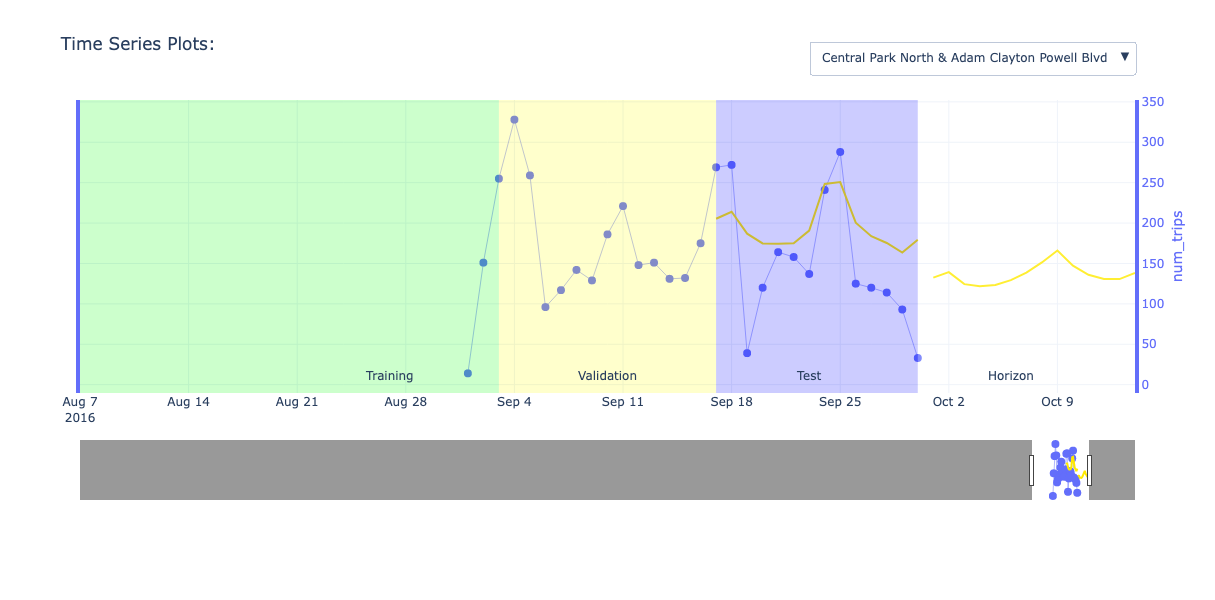

In [87]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = test_predictions[test_predictions[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = test_predictions[test_predictions[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    name = f'Forecast: {v}',
                    text = test_predictions[test_predictions[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            fig.add_trace(
                go.Scatter(
                    x = predict[predict[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = predict[predict[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    name = f'Forecast: {v}',
                    text = predict[predict[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 2 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


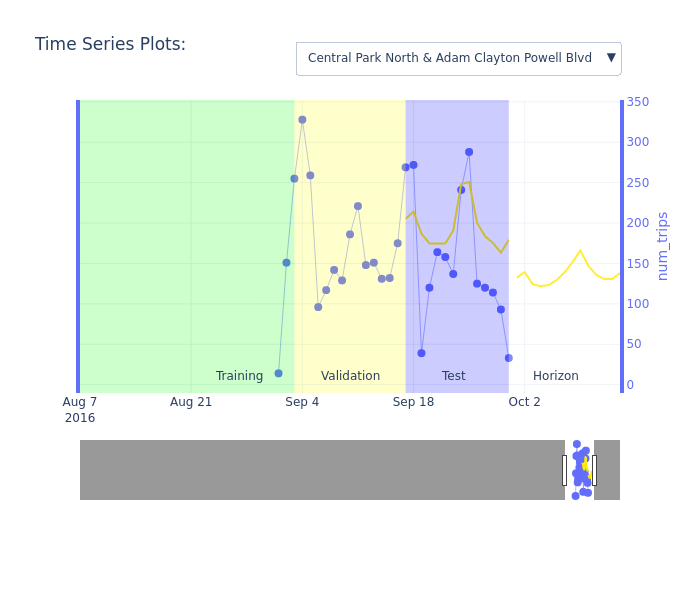

In [88]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Remove Resources
see notebook "99 - Cleanup"